In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

pd.set_option("display.float_format", lambda x: "%.8f" % x)
%load_ext lab_black
%load_ext nb_black
%matplotlib inline

import warnings

warnings.filterwarnings("ignore")

---
# Fetching decoded ADS-B data from OpenSky

In [2]:
from pymodes_opensky import OpenskyImpalaWrapper

opensky = OpenskyImpalaWrapper()

**Server connection successful!


## Example flight 1

In [3]:
# Flight-1
adsb1 = opensky.query(
    type="adsb", start="2019-07-07 11:00:00", end="2019-07-07 13:30:00", icao24="4844C6"
)

**Obtaining details of the query...
**OpenSky Impala: 7369 of records found.
**Fetching records...
**Records downloaded.


In [4]:
print(adsb1.columns.tolist())

['time', 'icao24', 'lat', 'lon', 'velocity', 'heading', 'vertrate', 'callsign', 'onground', 'alert', 'spi', 'squawk', 'baroaltitude', 'geoaltitude', 'lastposupdate', 'lastcontact', 'hour']


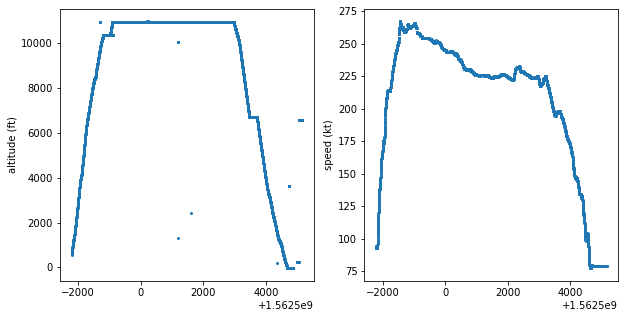

In [5]:
plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.scatter(adsb1.time, adsb1.baroaltitude, marker=".", lw=0)
plt.ylabel("altitude (ft)")

plt.subplot(122)
plt.scatter(adsb1.time, adsb1.velocity, marker=".", lw=0)
plt.ylabel("speed (kt)")
plt.show()

## Example flight 2

In [6]:
# Flight-2
adsb2 = opensky.query(
    type="adsb", start="2019-09-09 08:00:00", end="2019-09-09 12:00:10", icao24="4C01E4"
)

**Obtaining details of the query...
**OpenSky Impala: 6158 of records found.
**Fetching records...
**Records downloaded.


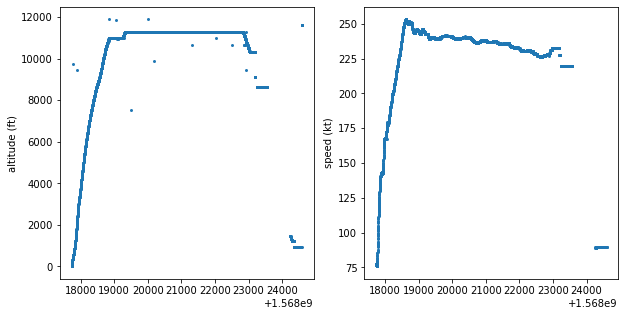

In [7]:
plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.scatter(adsb2.time, adsb2.baroaltitude, marker=".", lw=0)
plt.ylabel("altitude (ft)")

plt.subplot(122)
plt.scatter(adsb2.time, adsb2.velocity, marker=".", lw=0)
plt.ylabel("speed (kt)")
plt.show()

---
# Fetch RAW Mode-S data from OpenSky and decode

## Download RAW data only

In [8]:
df_raw = opensky.query(
    type="raw", start="2019-07-07 11:00:00", end="2019-07-07 13:30:00", icao24="4844C6"
)

**Obtaining details of the query...
**OpenSky Impala: 32380 of records found.
**Fetching records...
**Records downloaded.


In [9]:
print(df_raw.columns.tolist())

['rawmsg', 'mintime', 'maxtime', 'msgcount', 'icao24', 'message', 'isid', 'flightstatus', 'downlinkrequest', 'utilitymsg', 'interrogatorid', 'identifierdesignator', 'valuecode', 'altitude', 'identity', 'hour']


## Download and decode Comm-B data (slow when there are many rows)

In [10]:
from pymodes_opensky import EHSHelper

ehs = EHSHelper()

df_ehs = ehs.get(
    start="2019-07-07 11:00:00", end="2019-07-07 13:30:00", icao24="4844C6"
)

**Server connection successful!
**Obtaining details of the query...
**OpenSky Impala: 32380 of records found.
**Fetching records...
**Records downloaded.
**Processing data...


In [11]:
print(df_ehs.columns.tolist())

['icao24', 'time', 'rawmsg', 'bds', 'altitude', 'squawk', 'selalt40mcp', 'selalt40fms', 'p40baro', 'roll50', 'trk50', 'rtrk50', 'gs50', 'tas50', 'ias60', 'hdg60', 'mach60', 'vr60baro', 'vr60ins']


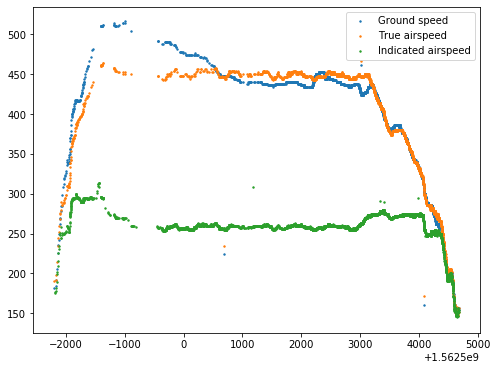

In [12]:
plt.figure(figsize=(8, 6))
plt.scatter(df_ehs.time, df_ehs.gs50, label="Ground speed", s=2)
plt.scatter(df_ehs.time, df_ehs.tas50, label="True airspeed", s=2)
plt.scatter(df_ehs.time, df_ehs.ias60, label="Indicated airspeed", s=2)
plt.legend()
plt.show()

---
# Visualize surveillance data with `traffic`

In [ ]:
from traffic.core import Traffic

In [14]:
adsb2["timestamp"] = pd.to_datetime(adsb2.time * 1e9).dt.tz_localize("utc")
adsb2["latitude"] = adsb2["lat"]
adsb2["longitude"] = adsb2["lon"]
adsb2["altitude"] = adsb2["baroaltitude"]

t = Traffic(adsb2)

In [15]:
t

,,count
icao24,callsign,
4c01e4,ASL20Z,5776


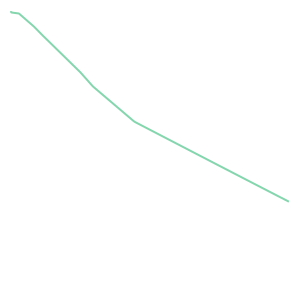

In [16]:
t["ASL20Z"]

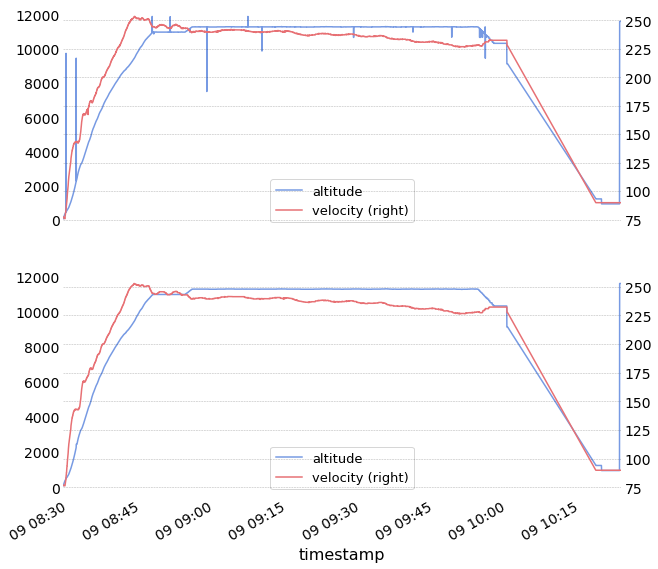

In [17]:
with plt.style.context("traffic"):
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
    t["ASL20Z"].plot_time(ax1, ["altitude", "velocity"], "velocity")
    t["ASL20Z"].filter().plot_time(ax2, ["altitude", "velocity"], "velocity")

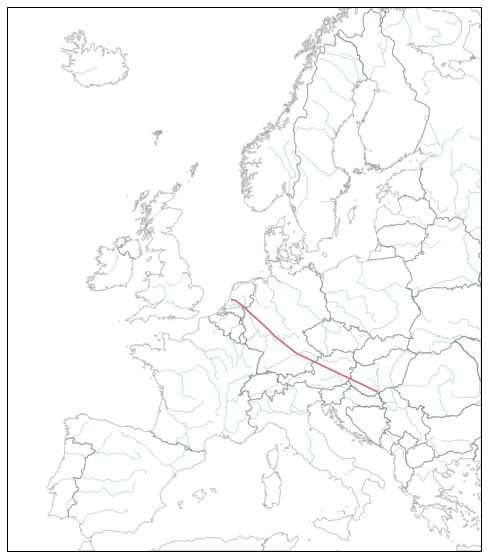

In [18]:
from traffic.drawing import EuroPP, rivers, countries

with plt.style.context("traffic"):
    fig, ax = plt.subplots(subplot_kw=dict(projection=EuroPP()))
    ax.add_feature(countries(edgecolor="#524c50", alpha=0.3))
    ax.add_feature(rivers(alpha=0.2))
    ax.set_global()

    # The map becomes too noisy if we plot everything
    t.plot(ax, nb_flights=100)

    # Plot a specific flight
    t["ASL20Z"].plot(ax)

In [19]:
from ipyleaflet import Map, basemaps
from ipywidgets import Layout

map_ = Map(
    center=(48.1, 11.5),
    zoom=5,
    basemap=basemaps.Stamen.Terrain,
    layout=Layout(width="100%", max_width="800px", height="500px"),
)

map_.add_layer(t["ASL20Z"], color="#990000", weight=2)

map_

Map(basemap={'url': 'https://stamen-tiles-a.a.ssl.fastly.net/terrain/{z}/{x}/{y}.png', 'attribution': 'Map til…